In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import pickle
#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [3]:
path_extracted_data = config.path_extracted_data
id_run = config.id_run
path_extracted_data_adap = os.path.join(path_extracted_data,'Adaptability')
print(id_run)

ALLDATA_


# Download data

In [4]:
#data used in random regression model
df = pd.read_csv(os.path.join(path_extracted_data_adap,'df_MVT_4individuality_withPCA.csv'), sep=',')
print(df.shape)
display(df.head(3))

(3230, 26)


,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment_encoded,perc_duration_5_Zone,perc_duration_4_Zone,...,nbr_stays_5_Zone_perh,nbr_stays_1_Zone_perh,in_WG_15mnAfterOpening,SleepingHeight,vertical_travel_distance_perh,avgDIB,severity,Feathers,Treatment,PC1
0,hen_134,11,MEXP,pen10,11.500000,1,1112,-1,100,0,...,0.1,0.0,0,3,0.0,33.357143,34,73.0,-1,-1.913797
1,hen_134,12,MEXP,pen10,10.166667,0,1112,-1,86,0,...,0.2,0.0,0,3,0.6,33.357143,34,73.0,-1,-1.621394
2,hen_134,13,MEXP,pen10,9.000000,0,1112,-1,100,0,...,0.1,0.0,0,3,0.0,33.357143,34,73.0,-1,-1.913797


In [5]:
#download predictability estimates
df_pred = pd.read_csv(os.path.join(path_extracted_data_adap,'BLUPS_variability.csv'), sep=',')
print(df_pred.shape)
display(df_pred.head(3))
print(list(df_pred.columns))
#sd_HenID__sigma_Intercept: is the estimate for individual differences in residual variance
#b_sigma_Intercept: is the population level estimate of the residual variance
li_col = [x for x in df_pred.columns if 'r_HenID__sigma' in x]
df_pred = df_pred[li_col]
display(df_pred.head(3))
#melt data for simplicity
df_pred['run'] = df_pred.index
df_pred = pd.melt(df_pred, id_vars=['run'], value_vars=li_col)
df_pred['HenID'] = df_pred['variable'].map(lambda x: x.split('r_HenID__sigma.')[1].split('.')[0])
#"Importantly, in order to assess whether individuals differ in variance the residual part of the model iscalculated on the log 
#scale! In order to interpret rIIV in biological terms we backtransform rIIV by takingit’s original scale by taking its exponent"
df_pred['Variability'] = df_pred['value'].map(lambda x: np.exp(x))
df_pred['Predictability'] = df_pred['Variability'].map(lambda x: x*(-1))
print(df_pred.shape)
df_pred.head(3)

#predictability
df_pred_summarized = df_pred.groupby('HenID')['Predictability'].agg(lambda x: list(x)).reset_index()
df_pred_summarized['Predictability_mean'] = df_pred_summarized['Predictability'].map(lambda x: np.mean(x))
df_pred_summarized['Predictability_sd'] = df_pred_summarized['Predictability'].map(lambda x: np.std(x))
print(df_pred_summarized.shape)
df_pred_summarized.head(3)

(2500, 3360)


,X1.b_Intercept,X1.b_sigma_Intercept,X1.b_time,X1.b_time2,X1.b_avgDIB_scale,X1.b_Treatment_encoded,X1.b_temperature_C_avg_scale,X1.b_InitialWeight_scale,X1.sd_HenID__Intercept,X1.sd_HenID__time,...,X10.r_HenID__sigma.hen_85.Intercept.,X10.r_HenID__sigma.hen_87.Intercept.,X10.r_HenID__sigma.hen_9.Intercept.,X10.r_HenID__sigma.hen_90.Intercept.,X10.r_HenID__sigma.hen_92.Intercept.,X10.r_HenID__sigma.hen_95.Intercept.,X10.r_HenID__sigma.hen_97.Intercept.,X10.r_HenID__sigma.hen_98.Intercept.,X10.r_HenID__sigma.hen_99.Intercept.,X10.lp__
0,-2.274647,-0.757068,4.827640,-2.318563,0.064251,-0.210316,-0.032600,-0.089428,1.683626,3.117788,...,0.095230,0.267961,-0.308166,-0.161817,0.188579,-0.515850,-0.293070,-0.097691,-0.338254,-2663.443413
1,-2.174649,-0.739926,4.678601,-2.217696,-0.054496,-0.113891,-0.039163,-0.075633,1.689518,3.252493,...,-0.031927,0.312161,-0.296171,-0.172997,0.067771,-0.308379,-0.318444,0.013090,-0.473941,-2674.786420
2,-2.158235,-0.736831,4.486730,-2.052231,0.001007,-0.154989,-0.033001,-0.066423,1.934503,3.285184,...,0.345714,0.186462,-0.250092,0.053870,-0.019580,-0.181660,-0.172357,-0.025587,-0.374570,-2704.731073


['X1.b_Intercept', 'X1.b_sigma_Intercept', 'X1.b_time', 'X1.b_time2', 'X1.b_avgDIB_scale', 'X1.b_Treatment_encoded', 'X1.b_temperature_C_avg_scale', 'X1.b_InitialWeight_scale', 'X1.sd_HenID__Intercept', 'X1.sd_HenID__time', 'X1.sd_HenID__time2', 'X1.sd_HenID__sigma_Intercept', 'X1.cor_HenID__Intercept__time', 'X1.cor_HenID__Intercept__time2', 'X1.cor_HenID__time__time2', 'X1.r_HenID.hen_10.Intercept.', 'X1.r_HenID.hen_101.Intercept.', 'X1.r_HenID.hen_102.Intercept.', 'X1.r_HenID.hen_106.Intercept.', 'X1.r_HenID.hen_107.Intercept.', 'X1.r_HenID.hen_109.Intercept.', 'X1.r_HenID.hen_112.Intercept.', 'X1.r_HenID.hen_116.Intercept.', 'X1.r_HenID.hen_118.Intercept.', 'X1.r_HenID.hen_119.Intercept.', 'X1.r_HenID.hen_124.Intercept.', 'X1.r_HenID.hen_127.Intercept.', 'X1.r_HenID.hen_128.Intercept.', 'X1.r_HenID.hen_13.Intercept.', 'X1.r_HenID.hen_134.Intercept.', 'X1.r_HenID.hen_136.Intercept.', 'X1.r_HenID.hen_137.Intercept.', 'X1.r_HenID.hen_138.Intercept.', 'X1.r_HenID.hen_139.Intercept.', '

,X1.r_HenID__sigma.hen_10.Intercept.,X1.r_HenID__sigma.hen_101.Intercept.,X1.r_HenID__sigma.hen_102.Intercept.,X1.r_HenID__sigma.hen_106.Intercept.,X1.r_HenID__sigma.hen_107.Intercept.,X1.r_HenID__sigma.hen_109.Intercept.,X1.r_HenID__sigma.hen_112.Intercept.,X1.r_HenID__sigma.hen_116.Intercept.,X1.r_HenID__sigma.hen_118.Intercept.,X1.r_HenID__sigma.hen_119.Intercept.,...,X10.r_HenID__sigma.hen_84.Intercept.,X10.r_HenID__sigma.hen_85.Intercept.,X10.r_HenID__sigma.hen_87.Intercept.,X10.r_HenID__sigma.hen_9.Intercept.,X10.r_HenID__sigma.hen_90.Intercept.,X10.r_HenID__sigma.hen_92.Intercept.,X10.r_HenID__sigma.hen_95.Intercept.,X10.r_HenID__sigma.hen_97.Intercept.,X10.r_HenID__sigma.hen_98.Intercept.,X10.r_HenID__sigma.hen_99.Intercept.
0,0.172309,0.367227,-0.453652,0.268501,0.506245,0.482730,0.024989,-0.178372,0.171719,0.077233,...,-0.045059,0.095230,0.267961,-0.308166,-0.161817,0.188579,-0.515850,-0.293070,-0.097691,-0.338254
1,0.095999,0.159362,-0.716284,0.187366,0.405891,0.499287,-0.052564,-0.169077,0.028904,0.144277,...,-0.038658,-0.031927,0.312161,-0.296171,-0.172997,0.067771,-0.308379,-0.318444,0.013090,-0.473941
2,0.027972,0.158948,-0.780720,0.189569,0.474441,0.389854,0.020296,-0.040035,0.163698,0.032674,...,0.028823,0.345714,0.186462,-0.250092,0.053870,-0.019580,-0.181660,-0.172357,-0.025587,-0.374570


(2000000, 6)
(80, 4)


,HenID,Predictability,Predictability_mean,Predictability_sd
0,hen_10,"[-1.1880452374330899, -1.1007582807790317, -1....",-1.063352,0.114833
1,hen_101,"[-1.4437262575954668, -1.1727620215250427, -1....",-1.262059,0.144682
2,hen_102,"[-0.6353035730256499, -0.4885642392782376, -0....",-0.550980,0.069543


In [6]:
#MVT since begining: to add info on the first week
li_selected_hens = pickle.load(open(os.path.join(path_extracted_data_adap, 'li_selected_hens.pkl'), 'rb'))
print(len(li_selected_hens))
df_MVT_ALL = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';', 
                     parse_dates=['level'], dayfirst=True) 
print(df_MVT_ALL.shape)
df_MVT_ALL = df_MVT_ALL[df_MVT_ALL['HenID'].isin(li_selected_hens)]
#restrict to the adaptability study timeframe
df_MVT_ALL = df_MVT_ALL[df_MVT_ALL['level']<=config.max_date_adaptability]
print(df_MVT_ALL.shape)
#make sure we have their mvt
df_MVT_ALL = df_MVT_ALL[~df_MVT_ALL['perc_duration_5_Zone'].isnull()]
print(df_MVT_ALL.shape)
df_MVT_ALL.head(3)

80
(42300, 63)
(3750, 63)
(3750, 63)


,HenID,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate,Treatment,level,DIB,...,percChaoticTransition,night_Max_duration_zones,is_mvt_night,empproba_3_Zone,empproba_4_Zone,empproba_2_Zone,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open,SleepingHeight
114,hen_134,pen10,MEXP,tag_122,22black,4.0,2020-06-10 00:00:00,TRAN,2020-09-30,1,...,18.0,5_Zone,0.0,80.0,20.0,100.0,NaN,NaN,NaN,3
115,hen_134,pen10,MEXP,tag_122,22black,4.0,2020-06-10 00:00:00,TRAN,2020-10-01,2,...,0.0,5_Zone,0.0,0.0,0.0,0.0,NaN,NaN,NaN,3
116,hen_134,pen10,MEXP,tag_122,22black,4.0,2020-06-10 00:00:00,TRAN,2020-10-02,3,...,0.0,3_Zone,1.0,50.0,25.0,100.0,NaN,NaN,NaN,1


# Add nbr days within first three without mvt

In [7]:
m = df_MVT_ALL['DIB'].min()
print(m)
df_nomvt = df_MVT_ALL[df_MVT_ALL['DIB'].isin([m,m+1,m+2])].groupby('HenID')[['Total_number_zone']].agg(lambda x: list(x)).reset_index()
df_nomvt['nbr_daysnomvt_over_3days'] = df_nomvt['Total_number_zone'].agg(lambda x: sum([i==1 for i in x]))
print(df_nomvt.shape)
display(df_nomvt.head(3))
df_all = pd.merge(df, df_nomvt[['HenID','nbr_daysnomvt_over_3days']],  on='HenID', how='left')
print(df_all.shape)
df_all.head(3)

1
(80, 3)


,HenID,Total_number_zone,nbr_daysnomvt_over_3days
0,hen_10,"[4.0, 2.0, 1.0]",1
1,hen_101,"[2.0, 2.0, 3.0]",0
2,hen_102,"[4.0, 1.0, 1.0]",2


(3230, 27)


,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment_encoded,perc_duration_5_Zone,perc_duration_4_Zone,...,nbr_stays_1_Zone_perh,in_WG_15mnAfterOpening,SleepingHeight,vertical_travel_distance_perh,avgDIB,severity,Feathers,Treatment,PC1,nbr_daysnomvt_over_3days
0,hen_134,11,MEXP,pen10,11.500000,1,1112,-1,100,0,...,0.0,0,3,0.0,33.357143,34,73.0,-1,-1.913797,1
1,hen_134,12,MEXP,pen10,10.166667,0,1112,-1,86,0,...,0.0,0,3,0.6,33.357143,34,73.0,-1,-1.621394,1
2,hen_134,13,MEXP,pen10,9.000000,0,1112,-1,100,0,...,0.0,0,3,0.0,33.357143,34,73.0,-1,-1.913797,1


# Add predictability estimates

In [8]:
print(df_all.shape)
df_all = pd.merge(df_all, df_pred_summarized[['HenID','Predictability_mean','Predictability_sd']],  on='HenID', how='left')
print(df_all.shape)
df_all.head(5)

(3230, 27)
(3230, 29)


,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment_encoded,perc_duration_5_Zone,perc_duration_4_Zone,...,SleepingHeight,vertical_travel_distance_perh,avgDIB,severity,Feathers,Treatment,PC1,nbr_daysnomvt_over_3days,Predictability_mean,Predictability_sd
0,hen_134,11,MEXP,pen10,11.500000,1,1112,-1,100,0,...,3,0.000000,33.357143,34,73.0,-1,-1.913797,1,-0.853337,0.094453
1,hen_134,12,MEXP,pen10,10.166667,0,1112,-1,86,0,...,3,0.600000,33.357143,34,73.0,-1,-1.621394,1,-0.853337,0.094453
2,hen_134,13,MEXP,pen10,9.000000,0,1112,-1,100,0,...,3,0.000000,33.357143,34,73.0,-1,-1.913797,1,-0.853337,0.094453
3,hen_134,16,MEXP,pen10,7.833333,1,1112,-1,88,1,...,3,0.600000,33.357143,34,73.0,-1,-1.642858,1,-0.853337,0.094453
4,hen_134,17,MEXP,pen10,10.500000,0,1112,-1,98,0,...,3,0.363636,33.357143,34,73.0,-1,-1.819004,1,-0.853337,0.094453


In [9]:
dico_cl = {'MEXP':'MEXP','LEXP':'LEXP','EPI':'Others','LEXPLOST':'Others','MEXPLOST':'Others'}
df_all['CLASS'] = df_all['CLASS'].map(lambda x: dico_cl[x])
df_all['CLASS'].value_counts()

MEXP      1379
LEXP       965
Others     886
Name: CLASS, dtype: int64

In [10]:
df_all.to_csv(os.path.join(path_extracted_data_adap,'df_MVT_4stat_BI.csv'), index=False, sep=';')

# Visuals

In [11]:
print(df_all.shape)
df_all.head(3)

(3230, 29)


,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment_encoded,perc_duration_5_Zone,perc_duration_4_Zone,...,SleepingHeight,vertical_travel_distance_perh,avgDIB,severity,Feathers,Treatment,PC1,nbr_daysnomvt_over_3days,Predictability_mean,Predictability_sd
0,hen_134,11,MEXP,pen10,11.500000,1,1112,-1,100,0,...,3,0.0,33.357143,34,73.0,-1,-1.913797,1,-0.853337,0.094453
1,hen_134,12,MEXP,pen10,10.166667,0,1112,-1,86,0,...,3,0.6,33.357143,34,73.0,-1,-1.621394,1,-0.853337,0.094453
2,hen_134,13,MEXP,pen10,9.000000,0,1112,-1,100,0,...,3,0.0,33.357143,34,73.0,-1,-1.913797,1,-0.853337,0.094453


(80, 5)


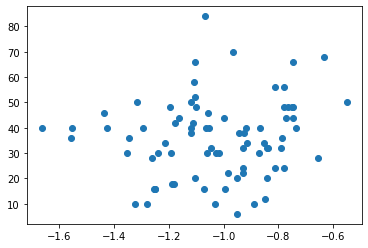

In [12]:
df_plt = df_all[['HenID','Predictability_mean','severity','Feathers','nbr_daysnomvt_over_3days']].drop_duplicates().copy()
print(df_plt.shape)
plt.scatter(df_plt['Predictability_mean'], df_plt['severity']);

C:\Users\camil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


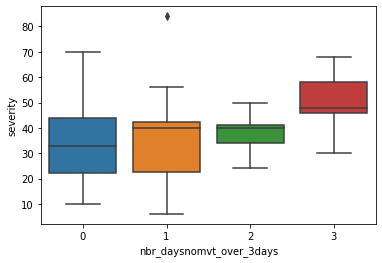

In [13]:
sns.boxplot('nbr_daysnomvt_over_3days','severity', data=df_plt);

In [14]:
df_plt['nbr_daysnomvt_over_3days'].value_counts()

0    52
1    16
2     7
3     5
Name: nbr_daysnomvt_over_3days, dtype: int64